In [13]:
%matplotlib notebook
from camera import take_picture
import matplotlib.pyplot as plt
from dlib_models import download_model, download_predictor, load_dlib_models
download_model()
download_predictor()
from dlib_models import models
import skimage.io as io
import numpy as np
from matplotlib.patches import Rectangle
import warnings
load_dlib_models()
face_detect = models["face detect"]
face_rec_model = models["face rec"]
shape_predictor = models["shape predict"]

class Face_Recognition:
    
    def __init__(self, upscale=1):
        self.upscale = upscale # number of times to upscale image before detecting
    
    def take_picture(self):
        return take_picture()

    def find_faces(self, pic, database):
        """
        Returns
        -------
        nothing
        """
        fig,ax = plt.subplots()
        ax.imshow(pic)
        desc_list = []
        name_list = []
        detections = list(face_detect(pic, self.upscale))
        for i in range(len(detections)):
            l, r, t, b = detections[i].left(), detections[i].right(), detections[i].top(), detections[i].bottom() 
            shape = shape_predictor(pic, detections[i])
            desc = np.array(face_rec_model.compute_face_descriptor(pic, shape))
            name = self.compare_faces(database, desc)
            desc_list.append(desc)
            name_list.append(name)
            ax.add_patch(Rectangle((l, b), r-l, t-b, Fill=None, alpha=1, color='yellow'))
            ax.text(l,b,name, color='white')
        return desc_list, name_list
    
    def compare_faces(self, database, desc):
        """keys are names
        iterate over database
        find best match and assign a name
        np.sqrt(np.sum((desc1 - desc2)**2))
        """
        # descript = a (128,) shape descriptor
        least = 1
        least_key = ""
        for key in database.items():
            v = np.sqrt(np.sum((desc-database.items()[key])**2))
            if least > v:
                least = v
                least_key = key
        print(least)
        if least > 0.45:
            return "No match found"
        else:
            return least_key
        
    def update_faces(self, desc_list, name_list, database):
        ans = input("Are the names and faces correctly matched? Unmatched faces will be added by your input. (y or n)")
        if ans == "y":
            for i in range(len(desc_list)):
                if name_list[i] == "No match found":
                    name = input("Please enter a name for this person.")
                    found = False
                    for x in database.items():
                        if name == x:
                            database.update_user_image(name, desc_list[i])
                            found = True
                    if found == False:
                        database.update(name, desc_list[i])
                else:
                    database.update_user_image(name_list[i], desc_list[i])
            print("database updated")
        else:
            print("database not updated")
    
    def file_read(self, file_id):
        img_array = io.imread(file_id)
        if (img_array.shape[2] == 4):
            img_array = img_array[:, :, :3]
        return img_array
    
    def name_faces_from_picture(self, database):
        pic = self.take_picture()
        desc, names = self.find_faces(pic, database)
        warnings.filterwarnings("ignore",".*GUI is implemented.*")
        try:
            plt.pause(0.5)
        except Exception:
            pass
        
        self.update_faces(desc, names, database)
        
    def name_faces_from_file(self, file_id, database):
        pic = self.file_read(file_id)
        desc, names = self.find_faces(pic, database)
        warnings.filterwarnings("ignore",".*GUI is implemented.*")
        try:
            plt.pause(0.5)
        except Exception:
            pass
        self.update_faces(desc, names, database)
        
    def add_new_from_file(self, file_id, database):
        pic = self.file_read(file_id)
        desc, names = self.find_faces(pic, database)
        desc = desc[0]
        warnings.filterwarnings("ignore",".*GUI is implemented.*")
        try:
            plt.pause(0.5)
        except Exception:
            pass
        name = input("Please enter a name for this person.")
        database.update(name, desc)
    
    def add_new_from_picture(self, database):
        pic = self.take_picture()
        desc = self.find_faces(pic, database)
        desc = desc[0]
        warnings.filterwarnings("ignore",".*GUI is implemented.*")
        try:
            plt.pause(0.5)
        except Exception:
            pass
        name = input("Please enter a name for this person.")
        database.update(name, desc)

File already exists:
	/Users/megankaye/Desktop/BeaverWorks/Work/Week2/DlibModels/dlib_models/dlib_face_recognition_resnet_model_v1.dat
File already exists:
	/Users/megankaye/Desktop/BeaverWorks/Work/Week2/DlibModels/dlib_models/shape_predictor_68_face_landmarks.dat


In [14]:
class Database():
    def __init__(self, file = None):
        """ initializes an object of the Database class.
                Parameters
                ----------
                file : (default None) an old database object. (as .npy) If a file is specified, the data from that file is
                        transferred over
                Variables
                -------
                variation: Classification if the variation is a song or the footprint. variation describes what type of
                          dictionary it is, whether it is song id and titles or frequency and song id
                dict: a new dictionary to store songs.
                """
        self.variation = 'Not Specified'
        if file is not None:
            self.dict = np.load(file).item()
        else:
            self.dict = {}

    def items(self):
        return self.dict
    
    def get(self, key):
        return self.dict[key]
    
    def update_user_image(self, key, val):
        self.dict[key] = (self.dict[key] + val)/2
        
    def update(self, key, val):
        self.dict[key] = val
        
    def def_variation(self, var):
        """ defines the variation, whether it be a song or a footprint.
                Parameters
                ----------
                var : (default None) a str named SONG or FP. (as .npy)"""
        self.variation = var

    def style(self):
        """ returns the variation style of the dictionary object """
        return 'Dict style is', self.variation

    def __repr__(self):
        """ The repr command; returns finger print followed by the song title and then artist """
        lines = ['Dictionary contains values of:', self.variation]
        for key, value in self.dict.items():
            lines.append('{}:{}'.format(key, value))
        return '\n'.join(lines)
        # delete this depending on what format the fp is in (possible hash), user might not care to see it

    def save_obj(self, file_name = 'dictionary.npy' ):
        """ saves the dictionary object
                Parameters
                ----------
                file_name : the name of the dictionary obj file that is being saved to be loaded at a later time """
        np.save(file_name, self.dict)
        return 'successfully saved'

    def switch_db(self, new_file, old_file_name = 'dictionary.npy'):
        """ switches databases based on a new file and an old file
                Parameters
                ----------
                new_file : the new database file name
                old_file_name : (default is the original database) the original file name """
        self.save_obj(old_file_name)
        self.__init__(new_file)
        return 'successfully loaded'

    def size(self):
        """ returns number of songs stored in the dictionary """
        return len(self.dict)

    def edit_values(self, key):
        """ edits a value in the database based on the dictionary key
                Parameters
                ----------
                key : the key of the obj that should be edited """
        new_val = input('What should the new value be?')
        self.dict[key] = new_val

        self.dict[key] = (new_value)
        print (self.dict)
        #fix this to be more generalized

    def edit_duplicates(self, key, second_value):
        self.dict[key].append(second_value)

    def add_song(self, _id, title = None, artist = None):
        """ checks if a song exists in the database and then adds it to the database.
                Parameters
                ----------
                _id :  the song id
                title : (default None) the title of the song
                artist : (default None) the artist of the song """
        if _id in self.dict:
            print('already in the dict')
        else:
            self.dict[_id] = (title, artist)

    def del_w_id(self, _id):
        """ deletes a song from the database based on its id
                Parameters
                ----------
                _id :  the song id to be deleted """
        del self.dict[_id]

    def del_w_title_and_artist(self, title, artist):
        """ deletes a song from the database based on its title and artist
                Parameters
                ----------
                title :  the song id to be deleted
                artist :  the song id to be deleted """
        del self.dict[self.get_id_by_song_and_artist(title, artist)]

    def get_song_by_id(self, _id):
        """ search song by id
                Parameters
                ----------
                _id :  the song id to be deleted """
        if _id in self.dict:
            return self.dict[_id]
        else:
            print('un-recognized song!')
        # still editing this method
        # can make it more user friendly by taking the input from the user and having the method call itself

    def get_id_by_song_and_artist(self, title, artist):
        """ search song id by title and artist
                Parameters
                ----------
                title :  the song id to be deleted
                artist :  the song id to be deleted """
        return list(self.dict.keys())[list(self.dict.values()).index((title, artist))]

    def add_freq_time(self, tuple_of_freq_time, tuple_of_id_time):
        """ update/add frequency and time for songs
                Parameters
                ----------
                tuple_of_freq_time :  tuple of frequencies for the song
                tuple_of_id_time :  tuple of times for the song """
        if tuple_of_freq_time in self.dict:
            self.edit_duplicates(tuple_of_freq_time, tuple_of_id_time)
        else:
            list_value = []
            list_value.append(tuple_of_id_time)
            self.dict[tuple_of_freq_time] = list_value

    def del_w_freq(self, tuple_of_freq_time):
        """ delete song based on frequency
                Parameters
                ----------
                tuple_of_freq_time :  tuple of frequencies for the song """
        del self.dict[tuple_of_freq_time]

    def get_byTuple(self, tupe):
        if tupe in self.dict:
            return self.dict[tupe]
        else:
            return None

    def get_list_of_ids(self):
        """ returns a list of song ids produced from all of the tuples of frequencies and time """
        l = []
        for key in self.dict:
            l.append(self.dict[key][0])
        return l

In [15]:
f = Face_Recognition()
d = Database("goodfile.npy")

In [24]:
for i in d.items():
    print(i)

AJ
Nick Stanisha
Amanda Wang
Noah Thompson
Ryan SoClassy
Megan Kaye
Brendan Kaye
Lucia Vilallonga
Dimitris Alexakos
Sanjana Cheerla
Michael Huang
Lilian Luong
Johnny Passarelli
David Kaye
AJ Cavallaro
Christine Zhao
Melanie Chen
Mary Kaye


<IPython.core.display.Javascript object>


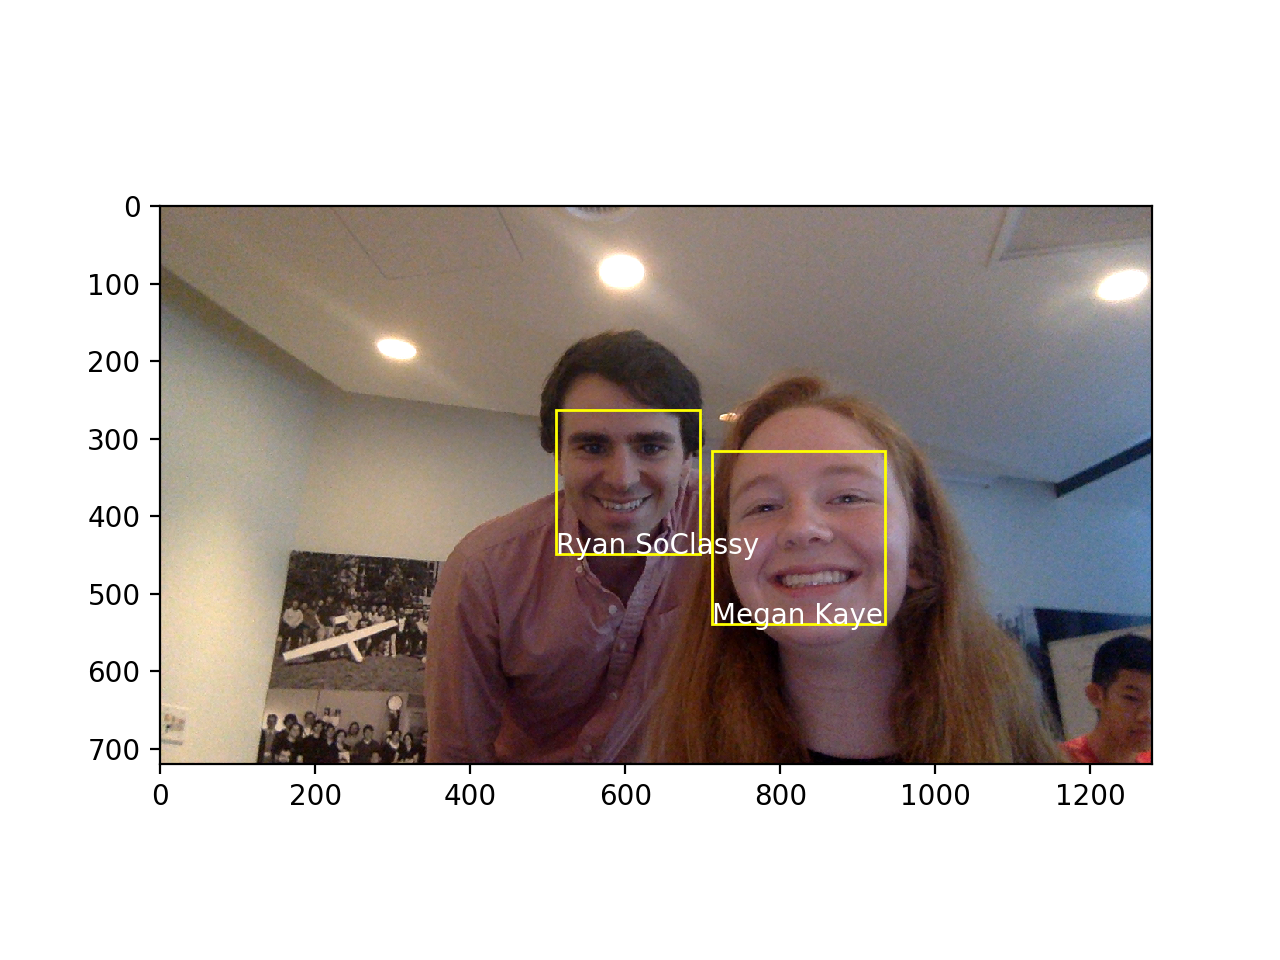

0.266398538259
0.406976678515
Are the names and faces correctly matched? Unmatched faces will be added by your input. (y or n)y
database updated


In [23]:
f.name_faces_from_picture(d)
#f.add_new_from_file("/Users/megankaye/Desktop/noah.png", d)
#f.name_faces_from_file("/Users/megankaye/Desktop/johnny2.png", d)
#fig.savefig("test.png")
#f.add_new_from_picture(d)

In [25]:
d.save_obj("goodfile.npy")

'successfully saved'